# Capstone Project - ARIMA Analysis
### DATA 606, Spring 2022, Dr. Chaojie Wang

#### Description: 
This notebook uses the ARIMA Machine Learning data to apply to the cleansed summary-level micromobility data generated in the 03 Clean for ML jupyter notebook.  This notebook will build the ARIMA model and attempt to use it to predict micromobility usage in the cities in our analysis.  

#### Dataset Sources: 
This uses the cleaned pre-grouped dataset generated by the 03 Clean for ML Jupyter Notebook.  This pre-grouped dataset is aggregated by city and by day for the period from January 2017 through December 2021.

## Function Definitions & Setup
This section deals with imports and function definitions

In [1]:
import pandas as pd
pd.__version__

'1.3.4'

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np

In [4]:
import glob

In [5]:
import os
from os.path import join, isdir
from os import mkdir, path

In [6]:
import datetime

In [7]:
# Import my helper py file to help with importing the data
import dfimporthelpers as imp

In [8]:
# For ACF and PACF plots that are used in SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## User Input Parameters
Specify the city for which to run the ARIMA analysis:

In [9]:
city = 'NYC'    # Change this to any of these: Chicago, NYC, San Francisco

<br><br>

## Load the prepared micromobility data that is pre-grouped for each city

In [10]:
dir_path = '/Users/DF/Library/CloudStorage/OneDrive-Personal/Documents/' + \
           'Grad School-David’s MacBook Pro/Spring 2022 - Capstone/JupyterNB/'

os.chdir(dir_path)

In [11]:
df = pd.read_csv('nyc_chicago_sf_tripsbydate_2017to2021.csv', low_memory=False, dtype='unicode')

In [12]:
# Set field types
df['year-month'] = pd.to_datetime(df['year-month']) 
df['#trips'] = df['#trips'].astype(int)

In [13]:
df.dtypes

city                        object
start_date                  object
year                        object
month                       object
year-month          datetime64[ns]
#trips                       int64
duration_minutes            object
dtype: object

<br />

### Group data by month
Note: This is the level that will be used for the ARIMA analysis.  Note that attempts to do the analysis by date was not feasible for the period of review as ARIMA requires significant resources to process with large data.  For example, training the model did not complete even when running overnight.  Therefore, the analysis instead pre-aggregates by month and that is used in the ARIMA model.

In [14]:
df_grouped = df.groupby(['year-month', 'city']).agg({'#trips': 'sum'}).copy().reset_index()

In [15]:
df = df_grouped

In [16]:
df.head()

,year-month,city,#trips
0,2017-01-01,Chicago,111942
1,2017-01-01,NYC,726676
2,2017-02-01,Chicago,166343
3,2017-02-01,NYC,791647
4,2017-03-01,Chicago,153406


In [17]:
# Set the year-month as the dataframe's index
df.set_index('year-month', inplace=True)

<br />

### View the data

In [18]:
df.head()

,city,#trips
year-month,,
2017-01-01,Chicago,111942
2017-01-01,NYC,726676
2017-02-01,Chicago,166343
2017-02-01,NYC,791647
2017-03-01,Chicago,153406


In [19]:
df.dtypes

city      object
#trips     int64
dtype: object

<br />

### Plot over Time

In [20]:
# Pivot to prepare to plot the years and cities
df_pivot = df.pivot(columns='city', values='#trips')

In [21]:
df_pivot.head(10)

city,Chicago,NYC,San Francisco
year-month,,,
2017-01-01,111942.0,726676.0,NaN
2017-02-01,166343.0,791647.0,NaN
2017-03-01,153406.0,727665.0,NaN
2017-04-01,268662.0,1315404.0,NaN
2017-05-01,345988.0,1523268.0,NaN
2017-06-01,505164.0,1731594.0,2689.0
2017-07-01,565142.0,1735599.0,44073.0
2017-08-01,557639.0,1816498.0,83292.0
2017-09-01,485489.0,1878098.0,98558.0


<Figure size 432x288 with 0 Axes>

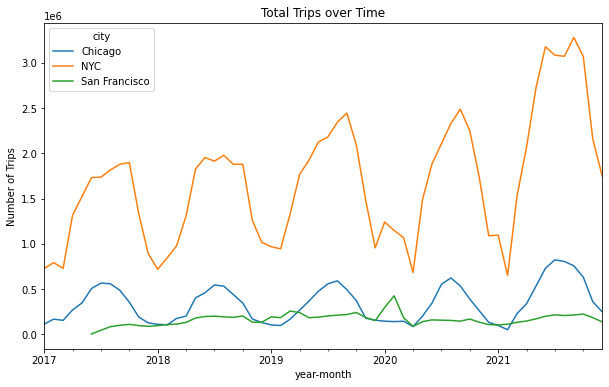

In [22]:
heading = 'Total Trips over Time'

plt.figure()
ax = df_pivot.plot.line(stacked=False, figsize=(10,6), title=heading)
ax.set_ylabel('Number of Trips')
    
# Display to screen
plt.show()

<br />

### Determine Parameters for the SARIMA Model
##### Reference Source: https://towardsdatascience.com/how-to-model-a-time-series-through-a-sarima-model-e7587f85929c

SARIMA(p,d,q)(P,D,Q)m

<ul>
    <li>p: order of the AR part</li>
    <li>d: degree of first differencing involved</li>
    <li>q: order of the moving average part</li>
    <li>P: Seasonal autoregressive order</li>
    <li>D: Seasonal difference order</li>
    <li>Q: Seasonal moving average order</li>
    <li>m: The number of time steps for a single seasonal period</li>
</ul>

In [23]:
# Filter the dataframe for the user specified city
if city != '':
    df = df[(df['city'] == city)]

### Determine Value of p by using an ACF plot. p generally corresponds to the maximum value in the ACF graph external to the confidence intervals.  However, this is an estimate.

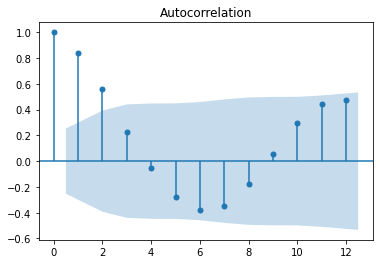

In [24]:
plot_acf(df['#trips'], lags=12)
plt.show()

#### Based on this, our p value will be 2

### Determine Value of d by using the Dickey-Fuller test to determine Stationarity

#### Source of function used: https://towardsdatascience.com/how-to-model-a-time-series-through-a-sarima-model-e7587f85929c

We will use the Dickey-Fuller test

In [25]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary", 'p value = ', pvalue)
        return True
    else:
        print("X is not stationary")
        return False

In [26]:
ts = df['#trips']

ts_diff = pd.Series(ts)
d = 0
while test_stationarity(ts_diff) is False:
    ts_diff = ts_diff.diff().dropna()
    d = d + 1

X is stationary p value =  8.980080653003017e-05


In [27]:
print('The value of d = ', d)

The value of d =  0


#### Based on this, our d value is 1

### Determine Value of q by using the PACF plot

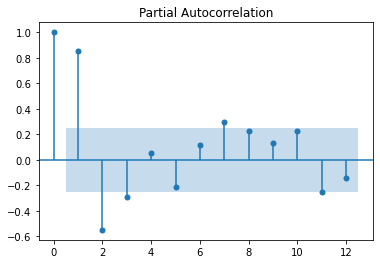

In [28]:
plot_pacf(df['#trips'], lags=12)
plt.show()

#### Based on this, our q value is 2 as it is the maximum value outside the confidence interval (blue shade)

### Train the Model
##### Source of Functions: https://towardsdatascience.com/how-to-model-a-time-series-through-a-sarima-model-e7587f85929c


In [29]:
num_rows = df.shape[0]

In [30]:
num_rows

60

In [31]:
ts = df['#trips']

train = ts.iloc[:-12]
test = ts.iloc[-12:]

In [32]:
print('All: ', ts.shape)
print('Train: ', train.shape)
print('Test: ', test.shape)

All:  (60,)
Train:  (48,)
Test:  (12,)


<br />

### Run the first cell below to use SARIMA, run the second cell to use ARIMA

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore') # ignore


# Use our parameter values as determined above
# (p,d,q)(P,D,Q)m
my_order = (2,1,2)
my_seasonalorder = (1,1,1,12)

model = SARIMAX(train, order=my_order, seasonal_order=my_seasonalorder)
model_fit = model.fit(disp=1,solver='powell')
    
# Predict the final 12 months
fcast = model_fit.get_prediction(start=(num_rows - 12), end=len(ts))
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03708D+01    |proj g|=  1.55314D-01

At iterate    1    f=  1.03638D+01    |proj g|=  5.35873D-02

At iterate    2    f=  1.03627D+01    |proj g|=  3.14618D-02

At iterate    3    f=  1.03619D+01    |proj g|=  4.00490D-02

At iterate    4    f=  1.03611D+01    |proj g|=  1.49582D-02

At iterate    5    f=  1.03608D+01    |proj g|=  1.07047D-02

At iterate    6    f=  1.03595D+01    |proj g|=  5.05817D-02

At iterate    7    f=  1.03579D+01    |proj g|=  7.24387D-02

At iterate    8    f=  1.03540D+01    |proj g|=  8.41802D-02

At iterate    9    f=  1.03492D+01    |proj g|=  8.49709D-02

At iterate   10    f=  1.03435D+01    |proj g|=  6.19166D-02

At iterate   11    f=  1.03378D+01    |proj g|=  4.22469D-02

At iterate   12    f=  1.03366D+01    |proj g|=  2.54864D-02

At iterate   13    f=  1.0

### Plot the results

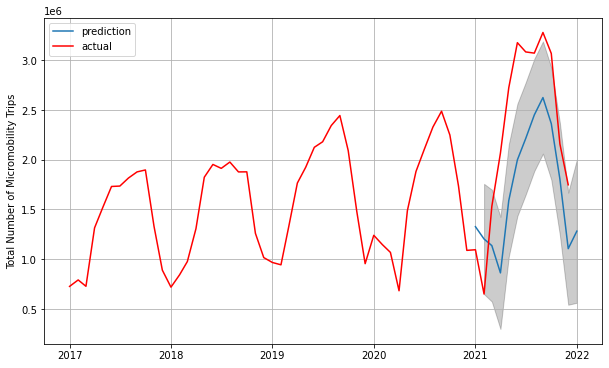

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(ts_p,label='prediction')
plt.plot(ts,color='red',label='actual')
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2)
plt.ylabel('Total Number of Micromobility Trips')
plt.legend()
#plt.tight_layout()
plt.grid()
plt.show()

### Assess performance using the Normalized Root-Mean Squared Error metric
##### Based on: https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa



In [35]:
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(ts_p.iloc[-12:], test)/(np.max(test)-np.min(test))
nrmse

0.28494365246940645